## pySCENIC

转录因子预测软件pySCENIC是基于SCENIC（Single-Cell rEgulatory Network Inference and Clustering）方法的Python实现版本，它是一种用于单细胞转录组数据的分析工具，能够推断转录因子活性并重建基因调控网络。pySCENIC的工作原理可以分为以下几个主要步骤：

1. 共表达网络推断（Co-expression network inference）：
在这一步，pySCENIC使用GRNBoost2算法或GENIE3算法来推断转录因子（TFs）与潜在靶基因之间的共表达关系。GRNBoost2是GENIE3的改进版本，它基于梯度提升决策树（Gradient Boosting Decision Tree, GBDT）来识别基因表达数据中的共表达模块。每个模块通常包含一个转录因子及其相关的靶基因，这种共表达关系是基于基因表达水平的相似性推断出来的。

2. 通过基因motif验证的调控网络模块（Regulons）：
在共表达网络推断完成后，pySCENIC进一步使用RcisTarget数据库来分析每个共表达模块中的基因，并鉴定富集的motifs。这些motifs是转录因子结合位点的短DNA序列，通过这些motif的富集程度，可以预测转录因子的潜在靶基因。最终，构建了一个包含转录因子和其直接靶基因的调控网络模块，称为regulons。

3. Regulons活性计算（Regulons activity calculation）：
最后一步是通过AUCell算法来计算每个regulon在所有细胞中的活性。AUCell通过计算每个细胞中regulons内所有基因的表达量累积曲线下面积（AUC, Area Under Curve）来量化regulon的活性。如果AUC值低于某个阈值，则认为该regulon在该细胞中未激活，即未发挥调控作用。

## 安装

```
pip install pyscenic #要求python3.7及以上版本
```

## 数据准备

#### 辅助数据库：

1. [cisTarget databases](https://resources.aertslab.org/cistarget/databases/)，比如人的可以在 [此处](https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/)下载
2. [Motif to TF annotations database](https://resources.aertslab.org/cistarget/motif2tf/)
3. [list of transcription factors ](https://resources.aertslab.org/cistarget/tf_lists/)

#### 表达矩阵：
一般情况下我们会用到loom文件，这里就做一个把表达矩阵保存成loom格式的示例：
```
import scanpy as sc
from scipy import io as sio
adata = sc.datasets.pbmc3k()
#做一下过滤
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
```

```
#保存为loom格式文件
import loompy as lp
def createLoom(adata, prefix='Sample.loom'):
    #如果是cellranger的输出目录，也可以用类似的方式获取对应的数据，mtx=sio.mmread('matrix.mtx'))
    mtx = adata.X.T 
    barcodes = adata.obs.index.tolist()
    features = adata.var.index.tolist()
    row_attrs = {'Gene':features}
    col_attrs = {'CellID':barcodes}
    lp.create(prefix, mtx, row_attrs, col_attrs)

createLoom(adata, 'pbmc3k.loom')
```

## 运行步骤：

第一步：
```
pyscenic grn --num_workers 32 --output pbmc3k.grn.tsv --method grnboost2 pbmc3k.loom database/allTFs_hg38.txt --cell_id_attribute CellID --gene_attribute Gene 
```

第二步：
```
pyscenic ctx pbmc3k.grn.tsv \
    database/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather database/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
    --annotations_fname database/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
    --expression_mtx_fname pbmc3k.loom  \
    --mode "custom_multiprocessing"  \
    --output pbmc3k.ctxOutput.regulons.tsv \
    --cell_id_attribute CellID --gene_attribute Gene \
    --mask_dropouts \
    --num_workers 32
```

第三步
```
pyscenic aucell pbmc3k.loom pbmc3k.ctxOutput.regulons.tsv -o auc_mtx.csv --num_workers 32 --cell_id_attribute CellID --gene_attribute Gene

```

这里呢，我们在提供一种方法备选，看起来有点麻烦，感觉还是用上面的方法更简单，但是作为一种选择，我们还是写在了下面：
```
import scanpy as sc
from dask.diagnostics import ProgressBar
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

ex_matrix = adata.to_df()
MOTIF_ANNOTATIONS_FNAME = 'database/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl'
dbs = ['database/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather', 
       'database/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather']

tf_names = load_tf_names('database/allTFs_hg38.txt')
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in dbs]

adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)
modules = list(modules_from_adjacencies(adjacencies, adata.to_df()))

with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME, num_workers=32)
regulons = df2regulons(df)
auc_mtx = aucell(ex_matrix, regulons, num_workers=12)
```

In [1]:
def qc(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
    return adata

In [2]:
def getRegulons(ctx_out_tsv):
    motifs = load_motifs(ctx_out_tsv, sep='\t')
    motifs.columns = motifs.columns.droplevel(0)

    x = motifs['NES'] >= 3.0 
    y = motifs['Annotation'] == 'gene is directly annotated'
    z = motifs['Annotation'].str.startswith('gene is orthologous to') & \
        motifs['Annotation'].str.endswith('which is directly annotated for motif')
    #regulons = df2regulons(motifs)
    regulons = df2regulons(motifs[(x & (y | z))])
    return regulons

In [3]:
def baseAnalysis(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3,
                                min_disp=0.5, n_top_genes=2000)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    #sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack', n_comps=30)
    sc.tl.tsne(adata)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.9, random_state=0, directed=False)
    return adata

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import io as sio

from pyscenic.export import add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

In [5]:
adata = sc.datasets.pbmc3k() #会直接下载的
#adata = sc.read_h5ad('data/pbmc3k_raw.h5ad')

In [6]:
#做一下过滤
adata = qc(adata)

In [7]:
#motifs = load_motifs('pbmc3k.ctxOutput.regulons.tsv', sep='\t')
#motifs.columns = motifs.columns.droplevel(0)

In [8]:
#https://motifcollections.aertslab.org/v9/logos/tfdimers__MD00488.png

In [10]:
regulons = getRegulons('pbmc3k_demo_pyscenic/pbmc3k.ctxOutput.regulons.tsv')

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [12]:
auc_mtx = pd.read_csv('pbmc3k_demo_pyscenic/auc_mtx.csv', index_col=0)
auc_mtx.columns = auc_mtx.columns.str.replace('(+)', '')

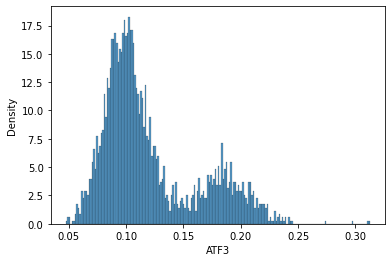

In [23]:
sns.histplot(auc_mtx.ATF3, bins=200, stat='density')
plt.savefig('pbmc3k_demo_pyscenic/ATF3.pdf')

In [14]:
adata = baseAnalysis(adata)

/usr/local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

/usr/local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


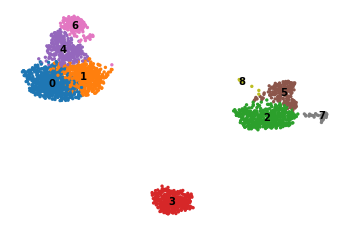

In [16]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", title="", frameon=False)

/usr/local/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


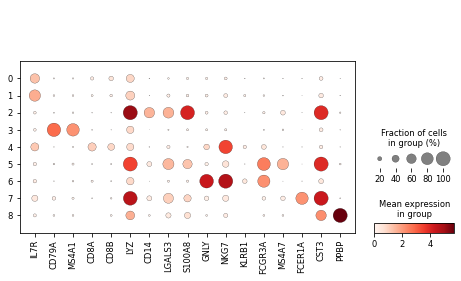

In [17]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")

In [24]:
new_cluster_names = {
    '0':"CD4 T",
    '1':"CD4 T",
    '2':"CD14+ Monocytes",
    '3':"B",
    '4':"CD8 T",
    '5':"FCGR3A+ Monocytes",
    '6':"NK",
    '7':"Dendritic",
    '8':"Megakaryocytes"
}

In [25]:
adata.obs['cellType'] = adata.obs.leiden.apply(lambda x: new_cluster_names[x])

In [35]:
plt.rcParams['figure.figsize'] = [10, 8]

/usr/local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


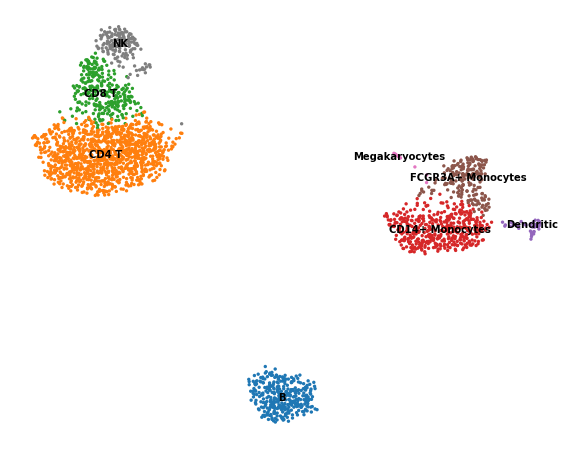

In [36]:
sc.pl.umap(adata, color="cellType", legend_loc="on data", title="", frameon=False)

In [38]:
auc_mtx_filter =auc_mtx.loc[:, [i.name[:-3] for i in regulons]]

In [39]:
add_scenic_metadata(adata, auc_mtx_filter, regulons)

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cellType', 'Regulon(ARID3A)', 'Regulon(ARNT)', 'Regulon(ARNTL)', 'Regulon(ATF1)', 'Regulon(ATF2)', 'Regulon(ATF3)', 'Regulon(ATF6)', 'Regulon(BACH1)', 'Regulon(BATF)', 'Regulon(BCL6)', 'Regulon(BCLAF1)', 'Regulon(CBFB)', 'Regulon(CEBPA)', 'Regulon(CEBPB)', 'Regulon(CEBPD)', 'Regulon(CREB1)', 'Regulon(CREB5)', 'Regulon(CREM)', 'Regulon(CTCF)', 'Regulon(CUX1)', 'Regulon(DDIT3)', 'Regulon(E2F3)', 'Regulon(E4F1)', 'Regulon(EGR1)', 'Regulon(ELF1)', 'Regulon(ELF2)', 'Regulon(ELF4)', 'Regulon(ELK1)', 'Regulon(ELK3)', 'Regulon(ELK4)', 'Regulon(EOMES)', 'Regulon(ETS1)', 'Regulon(ETS2)', 'Regulon(ETV6)', 'Regulon(ETV7)', 'Regulon(FLI1)', 'Regulon(FOS)', 'Regulon(FOXN3)', 'Regulon(FOXO1)', 'Regulon(GABPB1)', 'Regulon(GATA3)', 'Regulon(GMEB1)', 'Regulon(HOXB2)', 'Regulon(IKZF1)', 'Regulon(ING4)', 'Regulon(IRF1)', 'Regulon(IRF2)', 'Regulon(IRF4)', 

In [40]:
adata.write_h5ad('pbmc3k_demo_pyscenic/pbmc3k_with_scenic.h5ad')

In [41]:
rss = regulon_specificity_scores(auc_mtx_filter, adata.obs.cellType)

In [51]:
plt.rcParams['figure.dpi']=300

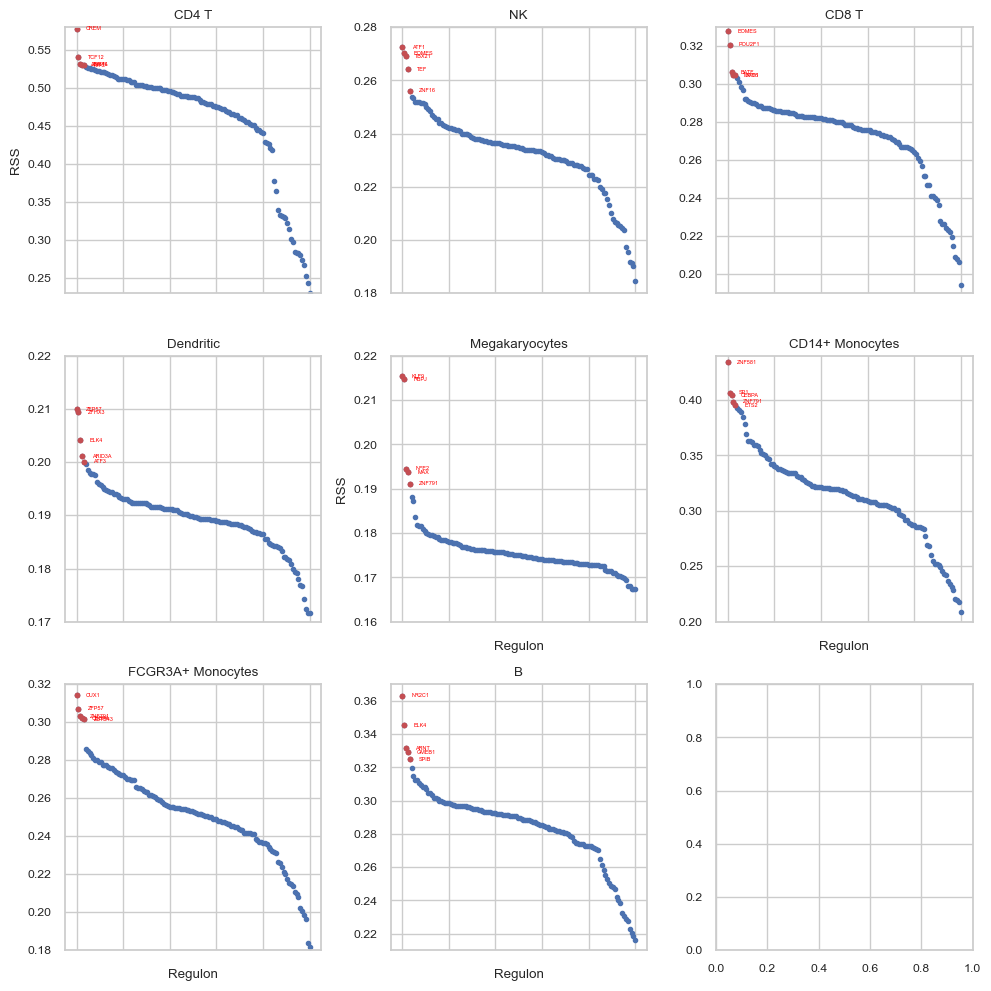

In [52]:
sns.set()
sns.set(style='whitegrid', font_scale=0.8)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10, 10), dpi=100)
plot_rss(rss, 'CD4 T', ax=ax1)
ax1.set_xlabel('')
plot_rss(rss, 'NK', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
plot_rss(rss, 'CD8 T', ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')
plot_rss(rss, 'Dendritic', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('')
plot_rss(rss, 'Megakaryocytes', ax=ax5)
plot_rss(rss, 'CD14+ Monocytes', ax=ax6)
ax6.set_ylabel('')
plot_rss(rss, 'FCGR3A+ Monocytes', ax=ax7)
ax7.set_ylabel('')
plot_rss(rss, 'B', ax=ax8)
ax8.set_ylabel('')
#plot_rss(rss, '', ax=ax9)
ax8.set_ylabel('')
plt.tight_layout()

In [43]:
tmp = rss.apply(lambda x: x.sort_values()[-5:].index.to_list(), 1)

In [44]:
tmp

CD4 T                    [MYC, ZNF44, ARNTL, TCF12, CREM]
B                        [SPIB, GMEB1, ARNT, ELK4, NR2C1]
FCGR3A+ Monocytes    [ZBTB43, CEBPA, ZNF791, ZFP57, CUX1]
NK                       [ZNF16, TEF, TBX21, EOMES, ATF1]
CD8 T                  [ATF6, TBX21, BATF, POU2F1, EOMES]
CD14+ Monocytes        [ETS2, ZNF791, CEBPA, SP1, ZNF581]
Dendritic              [ATF3, ARID3A, ELK4, ZFHX3, ZFP57]
Megakaryocytes            [ZNF791, MAX, NFE2, RBPJ, KLF9]
dtype: object

In [45]:
genes = ['cellType', ] + [f'Regulon({i})' for i in tmp[6]]

In [46]:
genes

['cellType',
 'Regulon(ATF3)',
 'Regulon(ARID3A)',
 'Regulon(ELK4)',
 'Regulon(ZFHX3)',
 'Regulon(ZFP57)']

/usr/local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


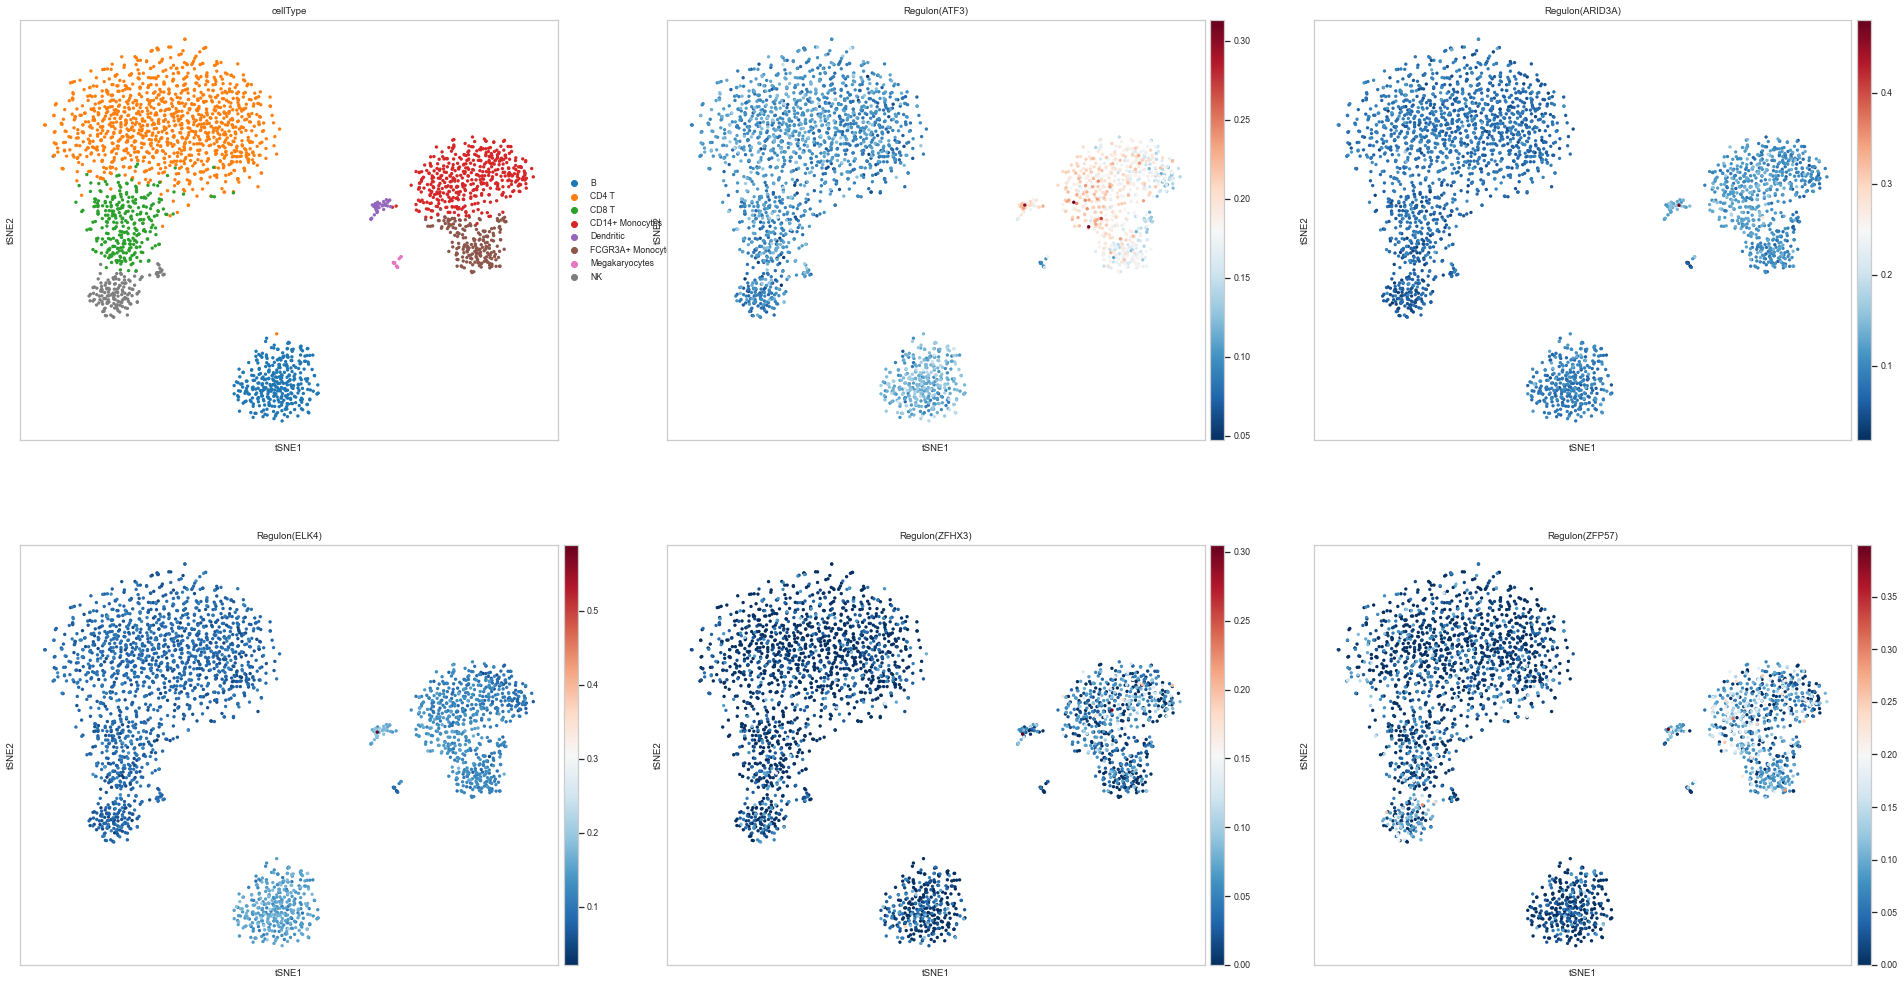

In [47]:
sc.pl.tsne(adata, color=genes,
           title=genes, ncols=3, use_raw=False,
          cmap=plt.cm.RdBu_r)